# Serie temporali

Una serie temporale è una sequenza di misure di un sistema che varia nel tempo. Un esempio famoso è il ["grafico della mazza da hockey"](https://en.wikipedia.org/wiki/Hockey_stick_graph) che mostra la temperatura media nel tempo della terra. 

In questo capitolo lavoreremo sui dati di Zachary M. Jones, un ricercatore di scienze politiche che ha studiato il mercato nero della cannabis negli stati uniti.

I dati sono disponibili sul seguente [sito](http://zmjones.com/marijuana), che a sua volta raccoglie i dati dal sito "Price of Weed" che raccoglie informazioni chiedendo ai partecipanti di riportare prezzo, quantità, qualità e posto della transazione il sito è raggiungibile al seguente [link](http://www.priceofweed.com/).
L'obiettivo di questo progetto è quello di analizzare l'effetto delle decisioni politiche, come ad esempio la legalizzazione sui mercati.

## Importazione dei dati e pulizia
Cominciamo con l'importare i dati nel DataFrame

In [1]:
import pandas as pd
transactions = pd.read_csv('./data/mj-clean.csv', parse_dates=[5])
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


Il DataFrame contiene una riga per ogni transazione riportata, qio sotto le colonne:

* city: Nome della citta
* state: sigla dello stato
* price: prezzo pagato in dollari
* amount: quantità acquistata in grammi
* quality: qualità valutata dall'acquirente high, medium, low quality
* date: data di acquisizione, presubilmente vicino alla data di acquisto.
* ppg: prezzo al grammo in dollari.
* state.name: nome dello stato
* lat: latitudine della transazione basata sulla città
* lon: longitudine approssimata della transazione


Ogni transazione è un evento nel tempo, perciò possiamo trattare questo dataset come una serie temporale. Gli eventi non sono equidistanti tra loro, il numero delle transazioni riportato ogni giorni varia tra 0 e qualche centinaio.
Molti metodi per analizzare le serie temporali richiedono che le misure siano equalmente distribuite, o almeno le cose sarebbero più semplici se questo parametro fosse rispettato.

Per dimostrare questi metodi, Dividiamo il dataset in gruppi in base alla qualità riportata, trasformiamo poi ogni gruppo in una serie di valori equidistanti calcolando la media giornaliera del prezzo per grammo.

In [2]:
import numpy as np

def GroupByQualityAndDay(transactions):
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies

`groupby` è una funzione messa a disposizione dall'oggetto DataFrame che ritorna un oggetto `GroupBy`.
La variabile `groups` viene poi usata in un ciclo che itera il nome del gruppo e il dataframe che rappresenta lo stesso
Poichè i valori della qualità sono low, medium e high avremo tre gruppi con lo questi nomi.

Il ciclo poi per ogni gruppo chiama la funzione `GroupByDay` che calcola la media giornaliera e restituisce un nuovo dataframe.

In [3]:
def GroupByDay(transactions, func=np.mean):
    groups = transactions[['date', 'ppg']].groupby('date')
    daily = groups.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily

Le date in questo DataFrame sono salvate come un oggetto `datetime64`di NumPy, che rappresenta un intero a 64 bit con la differenza in nanosecondi dalla data attuale al 01/01/1970 00:00:00. Per alcune analisi che vedremo dopo, può essere conveniente con delle date facimente leggibili tipo gli anni.

Nella funzione `GroupByDay` viene aggiunta una colonna che contiene il numero di anni passati dalla prima transazione in virgola mobile.

I DataFrame risultanti avranno le seguenti colonne ppg,date e years. 

In [4]:
dailies = GroupByQualityAndDay(transactions)

## Stampa valori
Il risultato della funzione `GroupByQualityAndDay` è una mappa per ogni qualità e prezzo giornaliero.
Visualizziamo queste tre serie temporali.

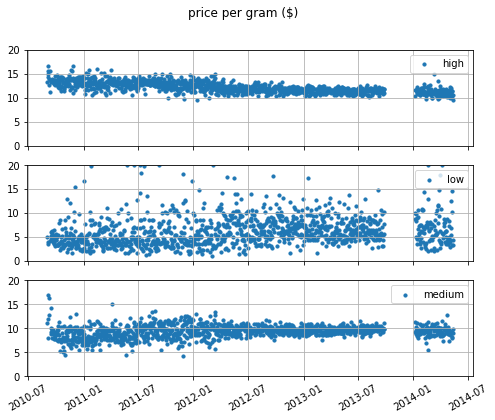

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize = (8, 6), sharex=True)
fig.suptitle('price per gram ($)')
for i, (name, daily) in enumerate(dailies.items()):
    axs[i].set_ylim([0, 20])
    axs[i].scatter(daily.index, daily.ppg, s=10, label=name)
    axs[i].legend(loc='upper right')
    axs[i].grid(True)
    
plt.xticks(rotation=30)
plt.show()

Visivamente, sembra che il prezzo della cannabis di buona qualità si abbassi durante questo periodo, mentre quello della qualità media si alzi. Il prezzo della bassa qualità potrebbe incrementare ma è difficile dirlo visto che il prezzo sembra molto volatile.

Teniamo a mente che la qualità è un dato riportato da volontri, quindi le tendenze nel tempo potrebbero riflettere i cambiamenti su come i partecipanti applicano queste etichette.

## Regressione Lineare
Sebbene ci siano metodi specifici per l'analisi delle serie temporali, per molti problemi una semplice strada è quella di applicare strumenti general-porpouse come la regressione lineare. 
La seguente funzione prende il DataFrame di prezzi giornalieri e calcola i minimi quadrati, restituendo il modello e i risultato di StatsModels:

In [6]:
import statsmodels.formula.api as smf

def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

In [7]:
def summarizeResults(results):
    """
    visualizza i parametri più importanti del modello di regressione
    """
    for name, param in results.params.items():
        pvalue = results.pvalues[name]
        print('%s   %0.3g   (%.3g)' % (name, param, pvalue))

    try:
        print('R^2 %.4g' % results.rsquared)
        ys = results.model.endog
        print('Std(ys) %.4g' % ys.std())
        print('Std(res) %.4g' % results.resid.std())
    except AttributeError:
        print('R^2 %.4g' % results.prsquared)

In [8]:
for name, daily in dailies.items():
    model, results = RunLinearModel(daily)
    print("\n Quality {0} --------------\n".format(name))
    
    summarizeResults(results)


 Quality high --------------

Intercept   13.4   (0)
years   -0.708   (3.69e-160)
R^2 0.4441
Std(ys) 1.096
Std(res) 0.8174

 Quality low --------------

Intercept   5.36   (3.15e-130)
years   0.568   (2.76e-09)
R^2 0.0296
Std(ys) 3.381
Std(res) 3.332

 Quality medium --------------

Intercept   8.88   (0)
years   0.283   (1.82e-15)
R^2 0.0499
Std(ys) 1.304
Std(res) 1.272


I valori stimati delle pendenze indicano che il prezzo della qualità più alta cala di 71 centesimi per anno durante il periodo osservato, per la media qualità si assiste a un incremento di 28 centesimi per anno e per la bassa qualità di 57 centesimi. 

Queste stime sono statisticamente significanti in quanto hanno un p-value molto piccolo.

Il valore di $R^2$ per l'alta qualità è circa 0.44, il che significa che il tempo come variabili indipendente spiega circa il 44% della variabilità osservata del prezzo.
Per le altre qualità il prezzo è più basso e la variabilità del prezzo è maggiore i valori di $R^2$ sono più piccoli ma ancora statisticamente significanti.

Il seguente codice visualizza i dati osservati e le previsioni del modello:

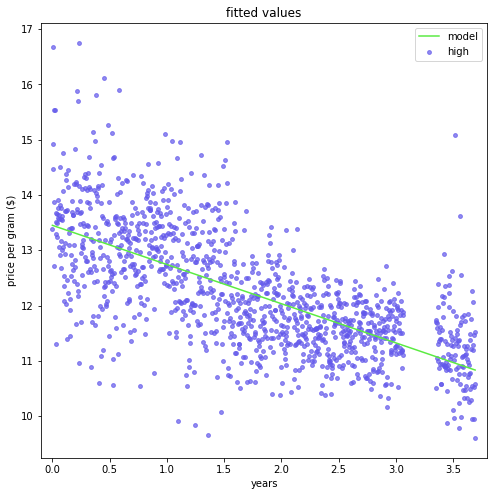

In [9]:
def PlotFittedValues(model, results, label=''):
    years = model.exog[:,1]
    values = model.endog
    plt.scatter(years, values, s=15, label=label,alpha=0.70,color="#6359EB")
    plt.plot(years, results.fittedvalues, label='model',color='#5BEB42')

    

name = 'high'
daily = dailies[name]
model, results = RunLinearModel(daily)


plt.figure(figsize=(8,8))
plt.title("fitted values")
plt.xlabel("years")
plt.xlim([-0.1, 3.8])
plt.ylabel('price per gram ($)')

PlotFittedValues(model, results,name)

plt.legend(loc='upper right')

La funzione PlotFittedValues crea un grafico a punti e la linea di regressione. La figura sopra mostra il risultato per la qualità alta della cannabis. Il modello lineare sembra adattarsi bene ai dati; tuttavia la regressione lineare non è la scelta più appropriata per questo tipo di dati:

* Primo non c'è nessuna ragione di aspettarsi che a lungo termine l'andamento sia lineare o una semplice funzione. In generale i prezzi sono determinati dalla offerta e dalla domanda ed entrambi variano nel tempo in modi imprevedibili.

* Secondo, la regressione lineare da egual peso a tutti i dati, recenti e passati. Ai fini della previsione, dovremmo probabilmente dare più peso ai dati recenti.

* Come ultimo punto, una delle assunzioni della regressione lineare è che i residuali siano rumore non correlato. Nei dati delle serie temporali, questa assunzione è spesso sbagliata in quanto i valori successivi sono spesso correlati. 

Nella prossima sezione analizziamo modi più approriati per analizzare le serie temporali.

# Medie Mobili
Molte analisi delle serie temporali si basano sulla assunzione che i dati osservati siano la somma di tre componenti:

* Tendenza: una funzione regolare che cattura i cambiamenti persistenti
* Stagionalità: una variazione periodica con regolarità giornaliera settimanale o annuali
* Rumore: variazioni random nel lungo periodo

La regressione è un metodo per estrarre l'andamento della serie, come abbiamo detto nella sezione precedente.
Ma se la tendenza non è una funzione semplice, una buona alteernativa è la media mobile.
La media mobile divide le serie in regioni sovrapposte, chiamate finestre, e calcoola le media dei valori in ogni finestra.

Una delle medie mobili più semplice è la media mobile semplice, che calcola la media di ogni finestra. Per esempio, se la dimensione della finestra è tre il valore delle medie verrà calcolata tra i valori tra 0 e 2 poi tra 1 e 3 e ancora poi tra 2 e 4, etc.

La libreria pandas fornisce il supporto per la media mobile, vediamo l'esempio qui sotto

In [10]:
series = np.arange(10)
series = pd.Series(series)
series

0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
8    8
9    9
dtype: int32

In [11]:
series.rolling(3).mean()

0    NaN
1    NaN
2    1.0
3    2.0
4    3.0
5    4.0
6    5.0
7    6.0
8    7.0
9    8.0
dtype: float64

Usiamo questo sistema per calcolare la media mobile del dataset Cannabis, prima di applicare questo metodo dobbiamo trattare i valori mancanti. Ci sono alcuni giorni in cui non sono riportate transazioni per una o più categorie e un periodo nel 2013 in cui i dati non sono stati raccolti.

Per rappresentare esplicitamente la mancanza del deta effettuiamo una operazione di "reindexing" del DataFrame:

In [12]:
dates = pd.date_range(daily.index.min(), daily.index.max())
reindexed = daily.reindex(dates)

La prima linea calcola il range di date tra la date di inizio e la data fine compresi i giorni mancanti, nella seconda riga viene costruito un nuovo DataFrame con tutti i giorni e nei giorni mancanti viene messo il valore `nan`.

Possiamo ora calcolare la media mobile e visualizzarne il suo andamento.

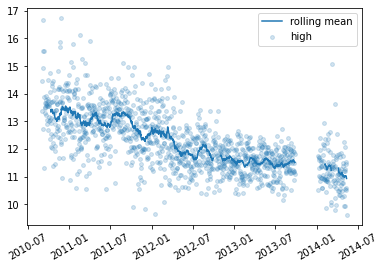

In [13]:
roll_mean = reindexed.ppg.rolling(30).mean()

plt.scatter(reindexed.index,reindexed.ppg, s=15, alpha=0.2, label=name)
plt.plot(reindexed.index,roll_mean,label='rolling mean')

plt.xticks(rotation=30)
plt.legend(loc='upper right')
plt.show()

La media mobile sembra fare un buon lavoro nell'attenuare il rumore ed estrarre l'andamento. I primi 29 valori sono `nan` e ovunque manca un valore questo è seguito da altri 29 `nan`. 

Una alternativa è la **Media mobile esponenziale** in inglese exponentially-weighted moving average (EWMA) che porta due vantaggi. 

* Primo come suggerisce il nome calcola una media pesata dove i valori più recenti hanno un peso maggiore e i valori precedenti decadono in importanza esponenzialmente  

* Secondo la libreria l'implementazione della libreria pandas gestisce meglio i valori mancanti. 


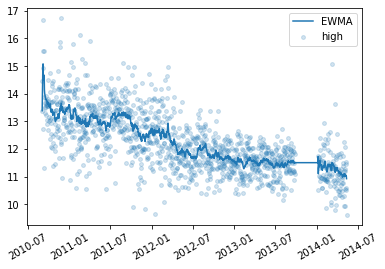

In [14]:
ewma = reindexed.ppg.ewm(span=30).mean()

plt.scatter(reindexed.index,reindexed.ppg, s=15, alpha=0.2, label=name)
plt.plot(reindexed.index,ewma,label='EWMA')

plt.xticks(rotation=30)
plt.legend(loc='upper right')
plt.show()

Il parametro span corrisponte all'incirca alla dimensione della finestra della media mobile, controlla quanto velocemente il pesi decadono, dunque il numero di punti che danno un contributo non trascurabile alla media.

Il grafico sopra è molto simile alla media mobile  ma non ha valori mancanti, il che rende più facile lavorare con esso.
I valori sono più rumorosi all'inizio in quanto sono basati su pochi dati.

## Valori mancanti

Abbiamo caratterizzato l'andamento di una serie temporale, il prossimo passo è quello di investigare sulla stagionalità, che rappresenta un comportamento periodico.
I dati delle serie temporali ganno spesso una periodicità giornaliera, mensile, annuale. Nella prossima sezione presentiamo un test per la stagionalità, ma questa non lavora bene sui dati mancanti dobbiamo risolvere questo punto prima.

Un semplice sistema è quello di impostare i dati mancanti con una media mobile. L'oggetto Series contiene il metodo fillna che fa proprio quello che vogliamo:

In [15]:
#reindexed.ppg.fillna(ewma, inplace=True)

Ovunque `reindexed.ppg` sia `nan` il metodo `fillna` rimpiazza lo stesso con il corrispondente valore di ewma. Il flag `inplace` specifica che `fillna` modifichi la serie di partenza senza crearne una nuova.

Uno svantaggio di questo metodo che che non prende in considerazione il rumore della serie. Possiamo risolvere il problema semplicemente aggiungendo i residui ricampionati:

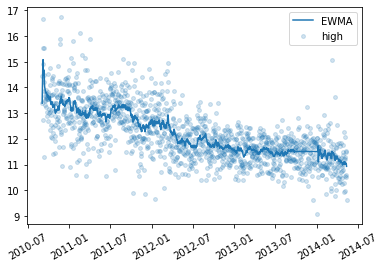

In [16]:
resid = (reindexed.ppg - ewma).dropna()
fake_data = ewma + np.random.choice(resid, len(reindexed), replace=True)
reindexed['ppg'].fillna(fake_data, inplace=True)
reindexed['ewma'] = ewma
reindexed['resid'] = reindexed.ppg - ewma

plt.scatter(reindexed.index,reindexed.ppg, s=15, alpha=0.2, label=name)
plt.plot(reindexed.index,ewma,label='EWMA')

plt.xticks(rotation=30)
plt.legend(loc='upper right')
plt.show()

I nuovi dati sono visualmente simili alla serie attuale. Poichè i dati ricampionati sono casuali, i risultati possono differire. Più avanti vedremo come caratterizzare gli errori creati dai valori mancanti. 

## Autocorrelazione
Il prezzo varia da giorno a giorno, possiamo aspettarci di trovare dei modelli. Se il prezzo è alto il lunedì, possiamo aspettarci che questo sarà alto per alcuni giorni mentre se il prezzo è basso possiamo aspettarci che questo sarà basso.

Un pattern come questo è chiamato autocorrelazione, perchè ogni valore è correlato con il prossimo della serie.
Per calcolare la correlazione seriale, possiamo spostare la serie temporale di un intervallo e calcolare la correlazine dei valori spostati con l'originale:

In [17]:
from utils import corr

def SerialCorr(series, lag=1):
    xs = series[lag:].values
    ys = series.shift(lag)[lag:].values
    cor = corr(xs, ys)
    return cor

Dopo lo spostamento i primi valori di lag sono `nan`, dunque usiamo lo slicing per rimuoverli prima di calcolare i valori di correlazione.

Se applicahiamo questa funzione ai dati grezzi con un lag di 1 ottenuamo i seguenti valori:

* 0.48 per la qualità alta
* 0.16 per la qualità media
* 0.10 per la qualità bassa

In una qualsiasi serie temporale con tendenza a lungo termine prevediamo di trovare forti correlazioni seriali, se per esempio i prezzi stanno scendendo ci aspettiamo di vedere valori sopra la media nella prima metà della serie e sotto la media nella seconda metà.

E' molto interessante vedere se la correlazione persiste sottrendo la tendenza, per esempio possiamo calcolare i residuali di EWMA e calcolare l'autocorrelazione:

In [18]:
SerialCorr(reindexed['resid'], lag=7)

0.007900874207560965

Se pensi che una serie possa essere autocorrelata, ma non si conosce quale parametro lag testare vanno provati tutti i possibili valori.

StatsModel, che abbiamo usato per la regressione lineare, ci fornisce una funzione per analizzare le serie temporali acf che calcola la funzione di autocorrelazione:

In [19]:
import statsmodels.tsa.stattools as smtsa
acf = smtsa.acf(reindexed['resid'], nlags=365, adjusted=True,fft=False)

`acf` calcola la correlazione seriale con il parametro lagns che parte da 0 fino al valore `nlags`. Il flag `adjusted` dice alla funzione acf di correggere le stime per la dimensione del campione.

Il risultato è un array di correlazioni. Se selezioniamo i prezzi giornalieri possiamo estrarre le correlazioni per i valori 1,7,30,265 il che conferma che acf e serialCorr danno all'incirca gli stessi risultati:

In [20]:
acf[7]

0.007873994179968757

## Previsioni
L'analisi delle serie temporali può essere usata per investigare e qualche volta spiegare il comportamento dei sistemi al variare del tempo.

La regressione lineaere usata nella sezione precedente può essere usata per fare delle previsioni. La classe RegressionResults ci fornisce il metodo `predict` che dato un DataFrame con le variabili indipendenti ritorna una sequenza di previsioni.

In [21]:
def GenerateSimplePrediction(results, years):
    n = len(years)
    inter = np.ones(n)
    d = dict(Intercept=inter, years=years)
    predict_df = pd.DataFrame(d)
    predict = results.predict(predict_df)
    return predict

Se tutto quello che vogliamo è una singola previsione siamo a posto. Ma per molti scopi è importante quantificare l'errore. In altre parole vogliamo conoscere quanto accurara sia la previsione.

Ci sono tre sorgenti di errore che dobbiamo tenere a conto:

* Errori di campionamento: La previsione è basata su parametri stimati che dipendono da variazioni randomiche nel campione. Se eseguiamo l'esperimento nuovamente ci aspettiamo che le stime varino.
* Variazioni Randomiche: Anche se le stime dei parametri fossero perfette i dati osservati variano randomicamnte in un lungo periodo e ci aspettiamo che le variazioni continuino in futuro.
* Errori di Modellazione: Abbiamo visto che i dati a lungo termine non sono lineari, dunque le previsioni basate sul un modello lineare eventualmente falliranno.

Un'altra sorgente di errori da considerare sono gli eventi futuri inaspettati. I prezzi dei prodotti agricoli sono influenzati dal meteo, e tutti i prezzi sono influenzati dalla politica e dalle leggi.


Per quantificare l'errore di campionamento, useremo il ricampionamento. Come sempre l'obiettivo è quello di usare le osservazioni attuali cosa succederebbe se eseguissimo l'esperimento di nuovo.
Le simulazioni sono basate che i parametri stimati siano corretti, ma i residuali potrebbero essere differenti. Questa è la configurazione che esegue le simulazioni:

In [22]:
def Resample(xs, n=None):
    if n is None:
        n = len(xs)
    return np.random.choice(xs, n, replace=True)


def SimulateResults(daily, iters=101):
    model, results = RunLinearModel(daily)
    fake = daily.copy()
    
    result_seq = []
    for i in range(iters):
        fake.ppg = results.fittedvalues + Resample(results.resid)
        _, fake_results = RunLinearModel(fake)
        result_seq.append(fake_results)

    return result_seq

`daily` è il dataframe contenente i prezzi osservati, `iters` è il numero di simulazioni da eseguire.
`SimulateResults` usa la funzione `RunLinearModel` che stima i parametri di parametri osservati.

Ogni volta che itera nel ciclo, viene gernato un dataset "fake" ricampionando i residuali e aggiungendo gli stessi ai valore predetti. 
Poi si esegue il modello lineare sui dati fake e si salva l'oggetto RegressionResults.

Il prossimo passo è quello di usare le simulazioni per generare le previsioni.

In [24]:
def GeneratePredictions(result_seq, years, add_resid=False):
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years)
    predict_df = pd.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

`GeneratePredictions` usa la sequenza dei risultati delle previsioni del passo precedent, così come `years` che rappresenta una sequenza di valori specifica l'intervallo per generare la previzione.

Il parametro `add_resid` indica sei bisogna agiungere i residuali ricampionati alla retta della previsione.
`GeneratePredictions` itera lungo la sequenza dei RegressionResults e genera una sequenza di previsioni.

Visualizziamo poi il grafico con un intervallo di confidenza del 90% delle previsioni:

In [27]:
def PercentileRow(array, p):
    rows, cols = array.shape
    index = int(rows * p / 100)
    return array[index,]


def PercentileRows(ys_seq, percents):
    nrows = len(ys_seq)
    ncols = len(ys_seq[0])
    array = np.zeros((nrows, ncols))

    for i, ys in enumerate(ys_seq):
        array[i,] = ys

    array = np.sort(array, axis=0)

    rows = [PercentileRow(array, p) for p in percents]
    return rows

def PlotPredictions(daily, years, iters=101, percent=90):
    result_seq = SimulateResults(daily, iters=iters)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, True)
    
    
    low, high = PercentileRows(predict_seq, percents)
    plt.fill_between(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, False)
    low, high = PercentileRows(predict_seq, percents)
    
    plt.fill_between(years, low, high, alpha=0.5, color='gray')

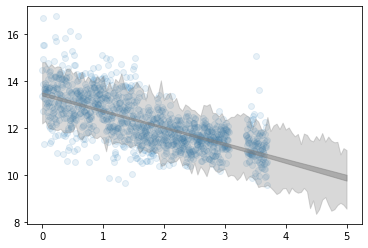

In [28]:
years = np.linspace(0, 5, 101)
plt.scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years)

`PlotPredictions` chiama la funzione `GeneratePredictions` due volte: la prima con il parametro `add_resid=True` e la seconda con `add_resid=False`. Viene usata la funzione `PercentileRows` per selezionare il 5 e il 95 percentile per ogni anno, viene poi mostrata una regione grigia che mostra l'intervallo.

La figura sopra mostra il risultato, la zona grigia rappresenta il 90% dell'intervallo di confidenza dell'errore di campionamento. 
La regione più chiara mostra il 90% dell'intevallo di confidenza dell'errore della previsione che è la somma dell'errore di campionamento e di una variazione random.  

Il modello di regressione è basato sulla assunzione che il sistema sia stazionario, cioè che i parametri del modello non varino nel tempo. Nello specifico si assume che i suoi parametri siano costanti, così come la distribuzione dei residuali.